# Векторизация текста

Для многих задач связанные с текстом нам бы хотелось представлять текст в виде вектора, чтобы похожие слова или предложения располагались рядом с друг другом. Для чего это нужно?. Например для задач поиска, нам хотелось бы выдавать ответ так, чтобы наиболее похожие статьи находились в верху списка. Такой тип представления текстов и слов называется дистрибутивная семантика. 
Каким же образом мы можем представить слова в таком виде?

Давайте ответим на вопрос, какое слово пропущено?

Житель местности, покрытой хвойным <i>....</i>, связывает с «деревом» прежде всего образ ели или сосны.

Мы понимаем что там должно стоять потому что видим так называемый контекст этого слова, те рядом стоящие слова которые дают достаточное представление даже если мы уберем какое то слово
Эта идея и лежит в алгоритме word2vec - слово это его контекст

Контекстом мы будем считать слова, которые находятся рядом с искомым словом в окне определенного размера, например для слова <i>лес</i> и окна 3, контекст выглядит следующим образом
- Житель <b>местности, покрытой хвойным</b> <i>лесом</i>, <b>связывает с «деревом»</b> прежде всего образ ели или сосны.

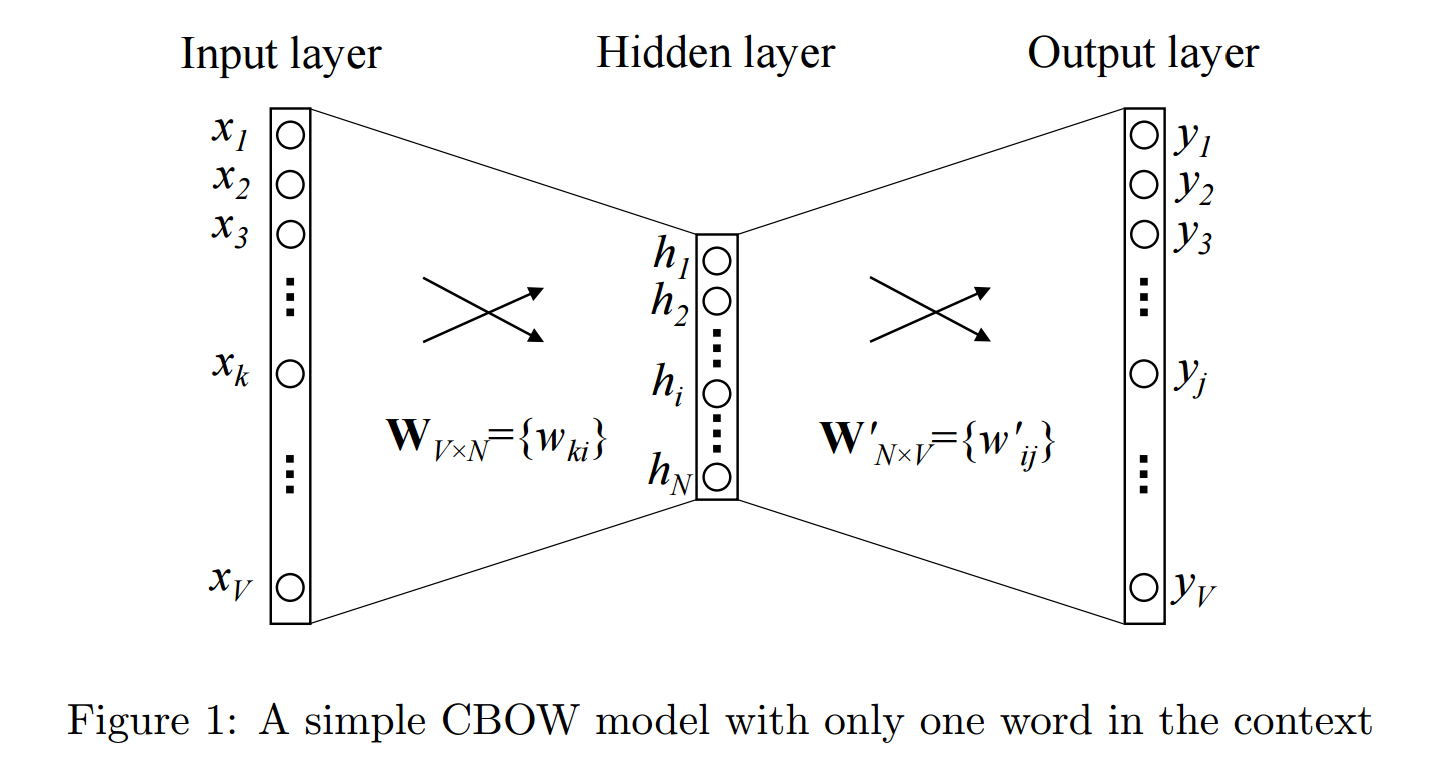Теперь у нас есть таргет и данные (контекст и слово в нем), осталось придумать под это дело нейросеть

У нас есть D - слов и у каждого из них должно быть векторное представление размера K, как этого добиться?
По сути можно завести линейней слой без смещения размера $D x K$ и в качестве входа передавать вектор размера D, где на всех позициях кроме порядкового номера текущего слова стоят нули а на нем 1, это называется one-hot encoding, тогда бы при умножение все веса бы обнулялись, кроме той строчки которая соответствует порядковому номеру нашего вектора.

Для этого есть специальный слой nn.Embedding для него не нужно делать one-hot векторизацию, достаточно передать порядковые номера.

И так мы уменьшили представление слова до размера K, теперь нам необходимо предсказать (контекст или слово), а для этого нужен опять выход размера D, здесь уже воспользуемся обычным линейным слоем

<img src="./img/w2v.png">

## Skip Gram

В данном случае мы пытаемся построить модель, которая бы предсказывала контекст по заданному слову:
$$\large{p(\omega_{i-k}..\omega_{i+k}|\omega_{i}) = \prod_{-k\le j\le k, j\ne 0}p(\omega_{i+j}|\omega{i})}$$
Где вероятность встречаемости каждого слова, представлена как:
$$\large{p(u|v) = \frac{e^{\phi_u\theta_v}}{\sum_{i\in W}e^{\phi_i\theta_v}}}$$
Используя знакомую нам кросэнтропию, максимизируем правдоподобие
$$\large{L = \sum_{u \in W}\sum_{v \in W}n_{uv}\log{p(u|v)}}$$
Однако на практике данной моделью пользуются редко, поскольку ее обучение занимает очень много времени из-за того что нам нужно считать софтмакс по всему словарю

### Negative sampling

Давайте положительные и отрицаельные примеры считать отдельно

- для положительных примеров (слов из контекста) 
$$\large{L_{positive} = \sum_{u \in W}\sum_{v \in W}n_{uv}\log{\sigma(\phi_u\theta_v)}}$$

- для отрицательных примеров (слов вне контекста), выбираем случайные k слов 
$$\large{L_{negative} = kE_v\log{\sigma(-\phi_u\theta_v)}}$$

Полная метрика выглядит как сумма позитивной и негативной метрик
$$\large L = L_{positive}+L_{negative}$$

## CBOW

Архитектура CBOW аналогична Skip-gram, с одним отличием, мы пытаемся максимизировать вероятность найти слово по заданному контексту

In [1]:
import json
import re
from collections import defaultdict
from pathlib import Path

import nltk
import pymystem3
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as nn_init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
data = []
for filename in Path("data/w2v_data/").rglob("*.jsonl"):
    with open(filename) as f:
        for line in f.readlines():
            json_line = json.loads(line)
            for key, value in json_line.items():
                if key.startswith("sentence"):
                    data.append(value)

In [3]:
len(data)

134174

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/imd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
lemmatizer = pymystem3.mystem.Mystem()

In [6]:
russian_word_re = re.compile("[а-яА-Я]")
to_space_re = re.compile(r"\W+")

In [7]:
stopwords = set(nltk.corpus.stopwords.words("russian"))

In [8]:
preprocessed_data = []
for sentence in data:
    sentence = to_space_re.sub(" ", sentence)
    lemmas = lemmatizer.lemmatize(sentence)
    preprocessed_sentence = [l for l in lemmas if russian_word_re.match(l) is not None and l not in stopwords]
    if len(preprocessed_sentence) > 1:
        preprocessed_data.append(preprocessed_sentence)

In [9]:
all_words_count = defaultdict(int)
for sentence in preprocessed_data:
    for word in sentence:
        all_words_count[word] += 1

In [10]:
len(all_words_count)

16432

In [11]:
word_to_id = {"<PAD>": 0}
word_list = ["<PAD>"]
for i, word in enumerate(all_words_count, start=1):
    word_list.append(word)
    word_to_id[word] = i

In [12]:
class WordDataset(Dataset):
    
    def __init__(self, sentences, word_to_id, window_size):
        self.sentences = sentences
        self.word_to_id = word_to_id
        self.window = window_size
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        word_index = np.random.randint(0, len(sentence) - 1)
        window_low = max(word_index - self.window, 0)
        window_max = min(word_index + self.window + 1, len(sentence))
        center = self.word_to_id[sentence[word_index]]
        context = []
        for i in range(window_low, window_max):
            if i != word_index:
                word = sentence[i]
                word_id = self.word_to_id[word]
                context.append(word_id)
        while len(context) < 2 * self.window:
            context.append(0)
        return torch.LongTensor(context), center

In [13]:
word_dataset = WordDataset(preprocessed_data, word_to_id, 2)

In [14]:
word_loader = DataLoader(word_dataset, 16, shuffle=True)

In [24]:
class Word2Vec(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        self.u = nn.Embedding(vocab_size, emb_size, padding_idx=0)
        self.v = nn.Linear(emb_size, vocab_size, bias=False)
        
    def forward(self, x):
        x = self.u(x)
        x = self.v(x)
        return x

In [26]:
model = Word2Vec(len(word_to_id), 128)

In [27]:
torch.manual_seed(42)

for name, parameter in model.named_parameters():
    if "weight" in name:
        nn_init.xavier_normal_(parameter)

In [28]:
model.cuda();

In [29]:
EPOCH = 100
SAMPLE_SIZE = 10
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
for e in range(EPOCH):
    for i, (context, center) in enumerate(word_loader):
        optimizer.zero_grad()
        context = context.cuda()
        center = center.cuda()
        out = model(center)
        negative_idx = torch.randint(0, len(word_to_id), size=(out.shape[0], SAMPLE_SIZE)).cuda()
        positive = torch.gather(out, 1, context)
        negative = torch.gather(out, 1, negative_idx)
        loss_positive = -torch.log(F.sigmoid(positive)) * (context != 0)
        loss_negative= -torch.log(F.sigmoid(-negative)).mean(dim=1) * SAMPLE_SIZE
        loss = loss_positive.sum(dim=1) + loss_negative
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        if i % (5000) == 0:
            print(f"Epoch: {e + 1} iteration: {i} loss: {loss.item()}")

Epoch: 1 iteration: 0 loss: 9.487772941589355
Epoch: 1 iteration: 5000 loss: 4.521111965179443
Epoch: 2 iteration: 0 loss: 4.303236484527588
Epoch: 2 iteration: 5000 loss: 4.796400547027588
Epoch: 3 iteration: 0 loss: 2.746898889541626
Epoch: 3 iteration: 5000 loss: 2.7294983863830566
Epoch: 4 iteration: 0 loss: 2.937014102935791
Epoch: 4 iteration: 5000 loss: 3.241495132446289
Epoch: 5 iteration: 0 loss: 1.893957257270813
Epoch: 5 iteration: 5000 loss: 1.369985580444336
Epoch: 6 iteration: 0 loss: 1.8399993181228638
Epoch: 6 iteration: 5000 loss: 2.9065306186676025
Epoch: 7 iteration: 0 loss: 1.0290738344192505
Epoch: 7 iteration: 5000 loss: 1.2596435546875
Epoch: 8 iteration: 0 loss: 1.6682685613632202
Epoch: 8 iteration: 5000 loss: 0.8295187950134277
Epoch: 9 iteration: 0 loss: 1.300689458847046
Epoch: 9 iteration: 5000 loss: 1.9675073623657227
Epoch: 10 iteration: 0 loss: 1.8615596294403076
Epoch: 10 iteration: 5000 loss: 0.5821210741996765
Epoch: 11 iteration: 0 loss: 1.2564053535

In [35]:
word_to_id["мочь"]

10

In [30]:
vectors = model.u.weight.data

In [31]:
vectors.shape

torch.Size([16433, 128])

In [32]:
vectors = vectors / vectors.norm(dim=1)[:, None]

In [36]:
dist = 1 - vectors[10].matmul(vectors.T)
closest_dist = torch.argsort(dist)[:10]
for idx in closest_dist:
    print(word_list[idx], dist[idx])

мочь tensor(0., device='cuda:0')
репутация tensor(0.6775, device='cuda:0')
пролив tensor(0.6839, device='cuda:0')
ботик tensor(0.6919, device='cuda:0')
раздаваться tensor(0.6953, device='cuda:0')
макроэкономический tensor(0.6979, device='cuda:0')
девятка tensor(0.6980, device='cuda:0')
пушистый tensor(0.7097, device='cuda:0')
высказывать tensor(0.7118, device='cuda:0')
мерзость tensor(0.7121, device='cuda:0')
